In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import category_encoders as ce
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [2]:
train = pd.read_csv('../input_data/airline_delay_train.csv')
test = pd.read_csv('../input_data/airline_delay_test.csv')

In [3]:
def feature_engg(df):
    
    df['FlightDate'] = pd.to_datetime(df['FlightDate'])
    df['year'] = pd.DatetimeIndex(df['FlightDate']).year.astype('category')
    df['month'] = pd.DatetimeIndex(df['FlightDate']).month.astype('category')
    df['day'] = pd.DatetimeIndex(df['FlightDate']).day.astype('category')
    df['hour'] = pd.to_datetime(df['DepTime'], format='%H:%M').dt.hour.astype('category')
    df['minutes'] = pd.to_datetime(df['DepTime'], format='%H:%M').dt.minute.astype('category')
    df['DepTime'] = pd.to_datetime(df['DepTime'], format='%H:%M').dt.time
    
    return df

In [4]:
train = feature_engg(train)

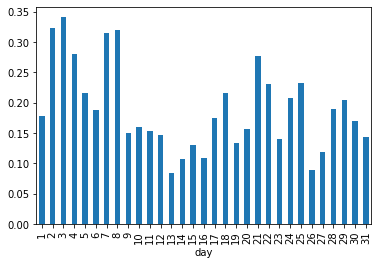

In [27]:
train.groupby(['day'])['dep_delayed_15min'].agg('mean').plot(kind = 'bar')


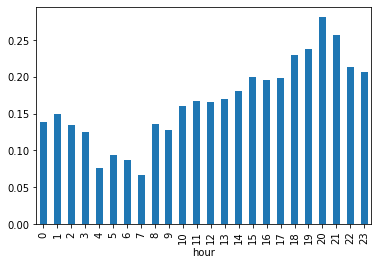

In [23]:
train.groupby(['hour'])['dep_delayed_15min'].agg('mean').plot(kind = 'bar')


In [5]:
test = feature_engg(test)

In [6]:
def split_df(df):
    
    X = df.drop('dep_delayed_15min', axis=1)
    y = df['dep_delayed_15min']

    return X, y

In [7]:
X, y = split_df(train)

In [8]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2)

In [9]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ordinal', ce.OrdinalEncoder())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, ['Distance']),
        ('cat', categorical_transformer, ['UniqueCarrier', 'Origin', 'Dest', 'Day_of_Week','year', 'month', 'day', 'hour', 'minutes'])])

rf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier())])

param_grid = {'classifier__n_estimators': [400]}

In [10]:
CV = GridSearchCV(rf, param_grid, n_jobs= -1,scoring='roc_auc')
CV.fit(X_train, y_train)  
print(CV.get_params())
print(CV.best_params_)    
print("{}{}".format("Cross - Validation: ", CV.best_score_))

{'cv': None, 'error_score': nan, 'estimator__memory': None, 'estimator__steps': [('preprocessor', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['Distance']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('ordinal',
                                                  OrdinalEncoder())]),
                                 ['UniqueCarrier', 'Origin', 'Dest',
                                  'Day_of_Week', 'year', 'month', 'day', 'hour',
                               

In [13]:
#print(CV.score(X_validation,y_validation))
print("{}{}".format("Validation: ", CV.score(X_validation,y_validation)))

X, y = split_df(test)
print("{}{}".format("Holdout: ", CV.score(X,y)))
#print(CV.score(X,y))

Validation: 0.7465015035542334
Holdout: 0.7475145815734953


In [1]:
target_names = y_validation.unique().astype(str)
y_pred = CV.predict(X_validation)
print(classification_report(y_validation, y_pred, target_names=target_names))

NameError: name 'y_validation' is not defined